In [1]:
import numpy as np
from sklearn import datasets
import pandas as pd
import math
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
#loading the data
wine_data = datasets.load_wine()
#dataframe to store the data
wine = pd.DataFrame(wine_data.data)
wine['label'] = wine_data.target
wine.columns=['Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280','Proline','Label']
wine.head()



,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline,Label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Description of the data

In [3]:
wine.describe(include="all")

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline,Label
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


due to mean,min and max values we don't have significant outliers

finding null values

In [11]:
print(wine.isna().sum())

Alcohol                 0
Malic acid              0
Ash                     0
Alcalinity of ash       0
Magnesium               0
Total phenols           0
Flavanoids              0
Nonflavanoid phenols    0
Proanthocyanins         0
Color intensity         0
Hue                     0
OD280                   0
Proline                 0
Label                   0
dtype: int64


label's histogram

In [27]:
fig = px.histogram(wine,x='Label')
fig.show()

heatmap for correlation

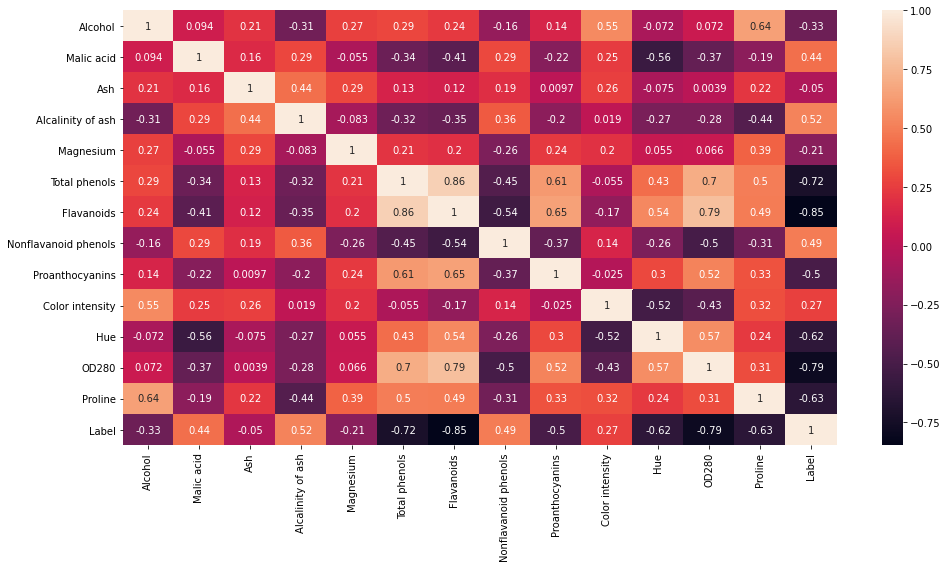

In [21]:
corr = wine.corr()
plt.figure(figsize = (16,8))
sns.heatmap(corr,annot=True)

visualizing the scatterplot matrix of all numeric attribute pairs for better understanding relationship between a pair of variables.

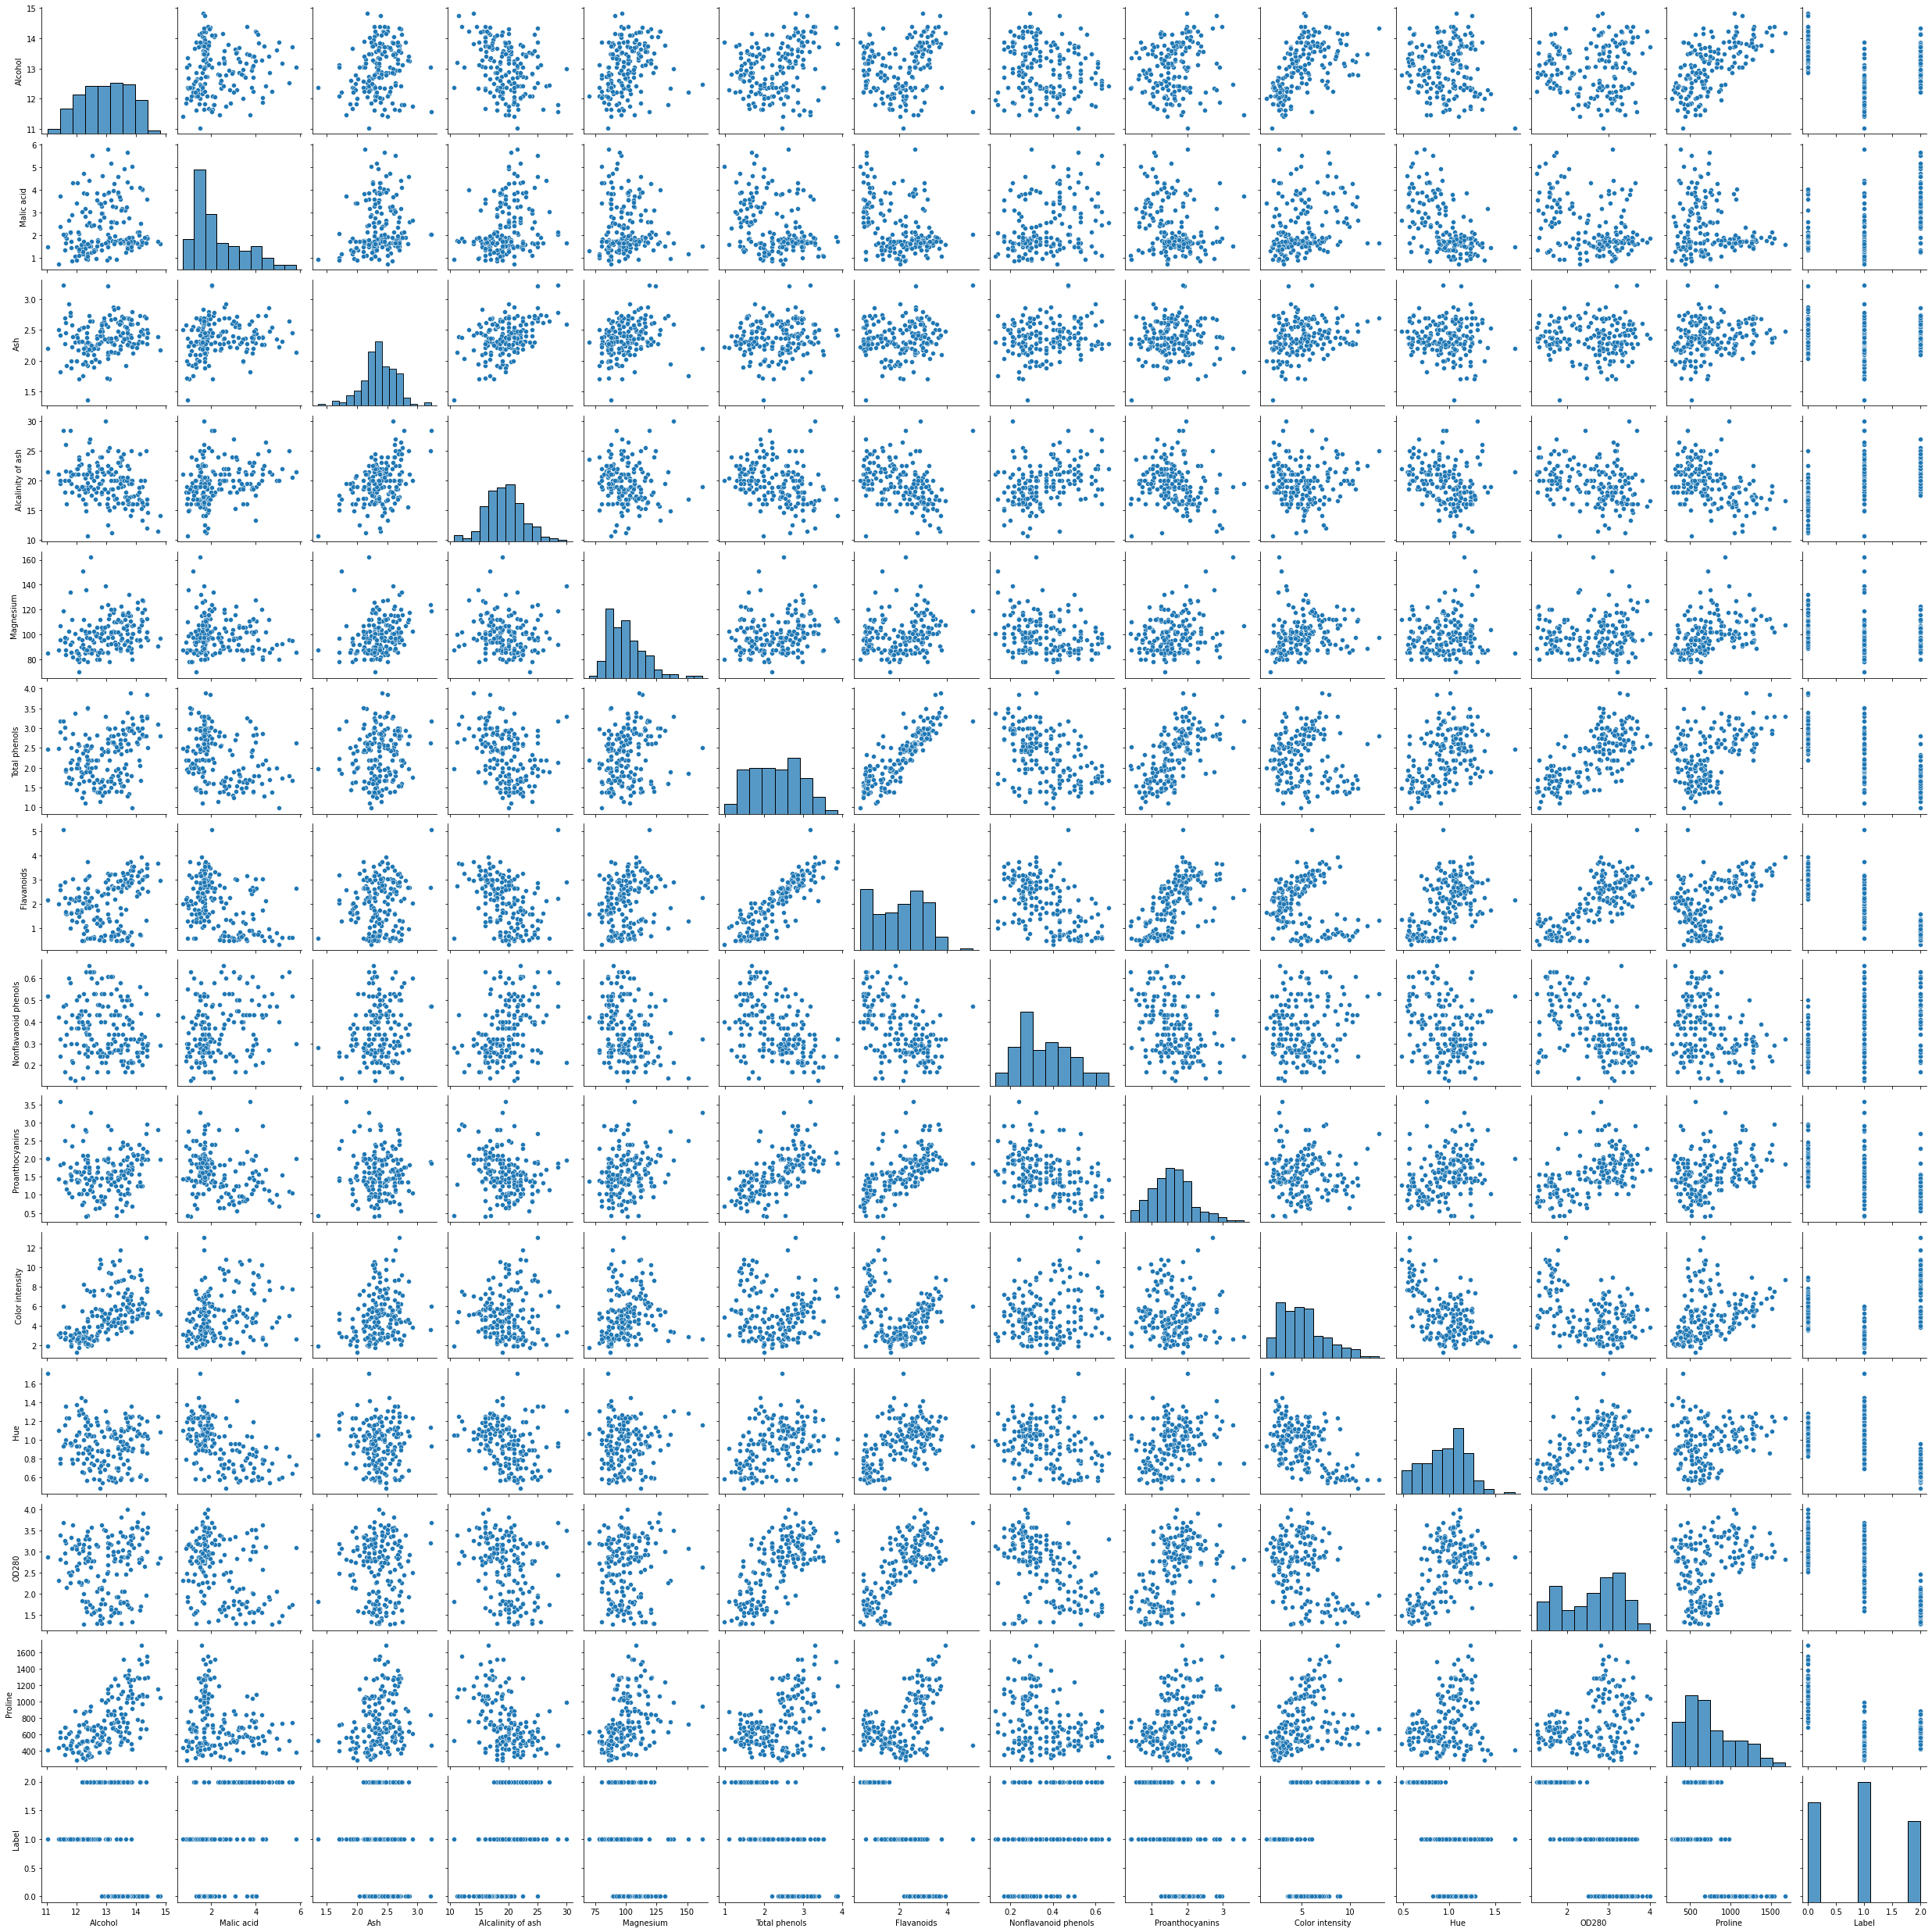

In [29]:
sns.pairplot(wine)

min-max Normalization

In [4]:
X = wine.drop(['Label'], axis=1).copy()
y = wine['Label']
min_max_scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(min_max_scaler.fit_transform(X))

X.columns=['Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280','Proline']
X['Label']=y
wine=X


In [5]:
wine.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline,Label
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,0
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,0
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,0
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,0
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,0


calculationg prior probablities p(c)

In [6]:
prior_prob={}
count=wine.Label.value_counts()
for i in range(3):
  prior_prob[i]=count[i]/len(wine['Label'])
print(prior_prob)

{0: 0.33146067415730335, 1: 0.398876404494382, 2: 0.2696629213483146}


function returns class with highest probablity

In [7]:
def find_class(train, test):
  class_probablity=prior_prob.copy()
  max = 0
  argmax = 0
  for c in class_probablity.keys():
    p_x_c=0
    #calculating p(X|c)
    row = train.loc[train['Label'] == c].to_numpy()
    for i in range(len(wine.columns)-1):
      r=row[:, i]
      mean= np.mean(r)
      variance=np.var(r)
      #p_x_c is p(x1|c)*..*p(xn|c)
      p_x_c = 1 / math.sqrt(2*math.pi*(variance **2))* math.exp(-((test[i]-mean)**2)/(2*variance**2))
    class_probablity[c] *=p_x_c
    #finding the class that maximizes p(x|c)
    if class_probablity[c] > max:
      max = class_probablity[c]
      argmax = c
  return argmax

6 fold cross validation

In [39]:

k=6
folds = []

#dividing the data to 6 parts
for i in range(k):
  folds.append(wine.iloc[int(len(wine)*i/k): int(len(wine)*(i+1)/k), :])
correct_prediction = 0
accuracy = 0

for i in range(k):
  #making the cross_fold_train data
  cross_fold_train=pd.DataFrame()
  for j in range(2,k-1,2):
    cross_fold_train = pd.concat([cross_fold_train,folds[j-1],folds[j]])
  if k%2==0:
    cross_fold_train=pd.concat([cross_fold_train,folds[k-1]])
  cross_fold_test = folds[0].copy()
  folds[0] = folds[(i+1)%k].copy()
  folds[(i+1)%k] = cross_fold_test.copy()
  #compare prediction with actual label
  for j in range(len(cross_fold_test)):
    row=cross_fold_test.iloc[j].to_numpy()
    predicted_class = find_class(cross_fold_train, row)
    if predicted_class == row[-1]:
      correct_prediction = correct_prediction+1
  accuracy = correct_prediction/len(wine)
print('correct predictions:'+str(correct_prediction)+" in "+str(len(wine)))
print("accuracy: "+str(accuracy))
        

correct predictions:127 in 178
accuracy: 0.7134831460674157
